In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [2]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [3]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427709 entries, 0 to 2427708
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 37.0 MB


# reduce to 1 million events

In [4]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [5]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,45760,0.08,45.760
1,45672,0.08,45.672
2,45702,0.08,45.702
3,45669,0.08,45.669
4,47549,0.08,47.549
...,...,...,...
999995,18930,0.19,18.930
999996,18966,0.19,18.966
999997,23885,0.15,23.885
999998,28910,0.12,28.910


### conversion Interval -> kWh

In [6]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,45760,0.08,45.760,78.671329
1,45672,0.08,45.672,78.822911
2,45702,0.08,45.702,78.771170
3,45669,0.08,45.669,78.828089
4,47549,0.08,47.549,75.711371
...,...,...,...,...
999995,18930,0.19,18.930,190.174326
999996,18966,0.19,18.966,189.813350
999997,23885,0.15,23.885,150.722211
999998,28910,0.12,28.910,124.524386


### Cumul Total interval

In [7]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [8]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26808003737000

### Calcul de la date de base = now - cumul_interval

In [9]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 18, 3, 16, 10, 520612)

In [10]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [11]:
conso_data.iloc[0]


Interval     45760.000000
kWh              0.080000
sec             45.760000
Wh              78.671329
cumul(ms)    45760.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [12]:
base

datetime.datetime(2024, 9, 18, 3, 16, 10, 520612)

## créer les dates

In [13]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-18 03:16:56.280612
1        2024-09-18 03:17:41.952612
2        2024-09-18 03:18:27.654612
3        2024-09-18 03:19:13.323612
4        2024-09-18 03:20:00.872612
                    ...            
999995   2025-07-25 09:54:33.926612
999996   2025-07-25 09:54:52.892612
999997   2025-07-25 09:55:16.777612
999998   2025-07-25 09:55:45.687612
999999   2025-07-25 09:56:14.257612
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [14]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,45760,0.08,45.760,78.671329,45760,2024-09-18 03:16:56.280612,18/09/24
1,45672,0.08,45.672,78.822911,91432,2024-09-18 03:17:41.952612,18/09/24
2,45702,0.08,45.702,78.771170,137134,2024-09-18 03:18:27.654612,18/09/24
3,45669,0.08,45.669,78.828089,182803,2024-09-18 03:19:13.323612,18/09/24
4,47549,0.08,47.549,75.711371,230352,2024-09-18 03:20:00.872612,18/09/24
...,...,...,...,...,...,...,...
999995,18930,0.19,18.930,190.174326,26807903406,2025-07-25 09:54:33.926612,25/07/25
999996,18966,0.19,18.966,189.813350,26807922372,2025-07-25 09:54:52.892612,25/07/25
999997,23885,0.15,23.885,150.722211,26807946257,2025-07-25 09:55:16.777612,25/07/25
999998,28910,0.12,28.910,124.524386,26807975167,2025-07-25 09:55:45.687612,25/07/25


### save conso_data with dates

In [15]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [16]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('25/07/25', 25, 7, 2025, '09:56:32')

In [17]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [18]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1087 entries, 998913 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1087 non-null   int64         
 1   kWh        1087 non-null   float64       
 2   sec        1087 non-null   float64       
 3   Wh         1087 non-null   float64       
 4   cumul(ms)  1087 non-null   int64         
 5   dates      1087 non-null   datetime64[ns]
 6   days       1087 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 67.9+ KB


In [19]:
end = time.time()
print(end - start)

23.093755960464478


### grouped by days

In [20]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [21]:
data = list(df_grp['kWh'])
print(data)

[1.546, 1.818, 1.821, 1.817, 1.815, 1.818, 1.817, 1.815, 1.819, 1.783, 1.788, 1.785, 1.784, 1.783, 1.798, 1.788, 1.791, 1.785, 1.792, 1.801, 1.798, 1.798, 1.802, 1.786, 1.786, 1.788, 1.788, 1.798, 1.791, 1.798, 1.805, 1.793, 1.801, 1.799, 2.629, 3.999, 3.683, 3.894, 3.093, 3.321, 4.165, 3.338, 3.531, 3.988, 3.323, 3.73, 3.567, 3.984, 3.204, 3.315, 3.371, 4.107, 3.289, 3.391, 3.816, 3.225, 3.55, 3.283, 3.921, 3.364, 3.409, 3.746, 4.405, 3.617, 3.85, 3.374, 4.224, 3.497, 3.448, 3.282, 3.862, 3.687, 4.109, 3.222, 3.724, 3.813, 3.152, 3.687, 3.635, 3.4, 3.886, 3.191, 4.055, 3.459, 3.684, 4.089, 3.402, 4.537, 3.264, 3.451, 3.121, 3.233, 3.417, 3.349, 3.435, 3.416, 4.585, 4.565, 3.231, 3.451, 3.634, 3.915, 3.561, 4.449, 4.182, 4.076, 3.8, 3.705, 3.576, 3.537, 4.39, 3.162, 3.372, 3.414, 3.448, 3.612, 3.371, 4.553, 3.261, 3.788, 3.246, 3.602, 3.545, 3.29, 3.975, 3.292, 4.65, 3.96, 3.318, 4.438, 3.507, 4.784, 3.812, 3.088, 3.223, 3.1, 3.589, 3.729, 3.98, 4.257, 3.422, 3.193, 3.89, 4.326, 3.404,

In [22]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [23]:
end = time.time()
print(end - start)

23.43786597251892


### plot function by day
#### show('dd/mm/yy')

In [24]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


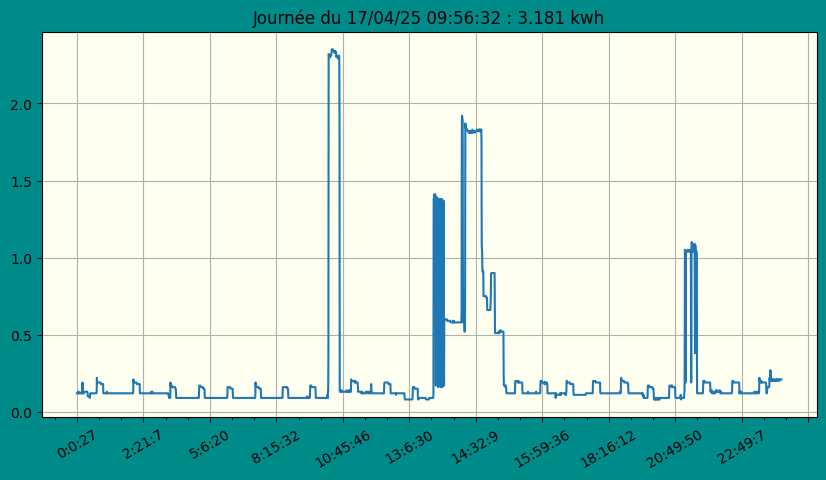

In [25]:
show('17/04/25')

In [26]:
end = time.time()
print(end - start)

24.818113565444946


### 1 kWh window in data of one day
#### df = conso_day

In [27]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998913,37289,0.10,37.289,96.543216,26772248688,2025-07-25 00:00:19.208612,25/07/25
998914,37149,0.10,37.149,96.907050,26772285837,2025-07-25 00:00:56.357612,25/07/25
998915,35339,0.10,35.339,101.870455,26772321176,2025-07-25 00:01:31.696612,25/07/25
998916,36165,0.10,36.165,99.543758,26772357341,2025-07-25 00:02:07.861612,25/07/25
998917,37397,0.10,37.397,96.264406,26772394738,2025-07-25 00:02:45.258612,25/07/25
...,...,...,...,...,...,...,...
999995,18930,0.19,18.930,190.174326,26807903406,2025-07-25 09:54:33.926612,25/07/25
999996,18966,0.19,18.966,189.813350,26807922372,2025-07-25 09:54:52.892612,25/07/25
999997,23885,0.15,23.885,150.722211,26807946257,2025-07-25 09:55:16.777612,25/07/25
999998,28910,0.12,28.910,124.524386,26807975167,2025-07-25 09:55:45.687612,25/07/25


In [28]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [29]:
df = conso_day
len(df)

1087

In [30]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-25 00:00:19.208612	2025-07-25 09:37:25.614612	9h 37m 6s 	1000
2025-07-25 09:37:25.614612	2025-07-25 09:56:14.257612	0h 18m 48s 	87


In [31]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.305944
dtype: float64

In [32]:
end = time.time()
print(end - start)

25.164660453796387


## mean for data grouped by days

In [33]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.215434
dtype: float64

In [34]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.087)

# conso by date


In [35]:
# select day
day = today

#day = '16/08/24'
day

'25/07/25'

In [36]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998913,37289,0.10,37.289,96.543216,26772248688,2025-07-25 00:00:19.208612,25/07/25
998914,37149,0.10,37.149,96.907050,26772285837,2025-07-25 00:00:56.357612,25/07/25
998915,35339,0.10,35.339,101.870455,26772321176,2025-07-25 00:01:31.696612,25/07/25
998916,36165,0.10,36.165,99.543758,26772357341,2025-07-25 00:02:07.861612,25/07/25
998917,37397,0.10,37.397,96.264406,26772394738,2025-07-25 00:02:45.258612,25/07/25
...,...,...,...,...,...,...,...
999995,18930,0.19,18.930,190.174326,26807903406,2025-07-25 09:54:33.926612,25/07/25
999996,18966,0.19,18.966,189.813350,26807922372,2025-07-25 09:54:52.892612,25/07/25
999997,23885,0.15,23.885,150.722211,26807946257,2025-07-25 09:55:16.777612,25/07/25
999998,28910,0.12,28.910,124.524386,26807975167,2025-07-25 09:55:45.687612,25/07/25


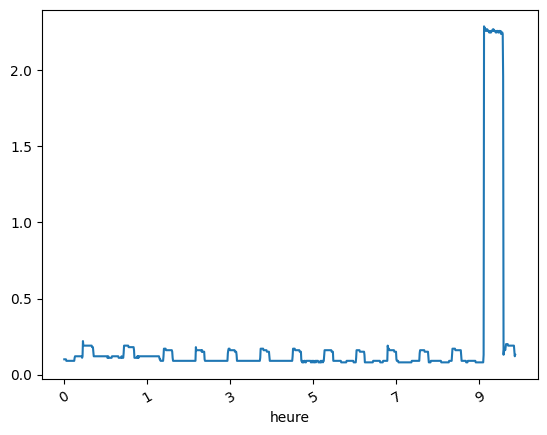

In [37]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [38]:
end = time.time()
print(end - start)

25.87811851501465


### grouped by 'heure'

In [39]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1087 entries, 998913 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1087 non-null   int64         
 1   kWh        1087 non-null   float64       
 2   sec        1087 non-null   float64       
 3   Wh         1087 non-null   float64       
 4   cumul(ms)  1087 non-null   int64         
 5   dates      1087 non-null   datetime64[ns]
 6   days       1087 non-null   object        
 7   heure      1087 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 76.4+ KB


In [40]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998913,37289,0.10,37.289,96.543216,26772248688,2025-07-25 00:00:19.208612,25/07/25
998914,37149,0.10,37.149,96.907050,26772285837,2025-07-25 00:00:56.357612,25/07/25
998915,35339,0.10,35.339,101.870455,26772321176,2025-07-25 00:01:31.696612,25/07/25
998916,36165,0.10,36.165,99.543758,26772357341,2025-07-25 00:02:07.861612,25/07/25
998917,37397,0.10,37.397,96.264406,26772394738,2025-07-25 00:02:45.258612,25/07/25
...,...,...,...,...,...,...,...
999995,18930,0.19,18.930,190.174326,26807903406,2025-07-25 09:54:33.926612,25/07/25
999996,18966,0.19,18.966,189.813350,26807922372,2025-07-25 09:54:52.892612,25/07/25
999997,23885,0.15,23.885,150.722211,26807946257,2025-07-25 09:55:16.777612,25/07/25
999998,28910,0.12,28.910,124.524386,26807975167,2025-07-25 09:55:45.687612,25/07/25


In [41]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [42]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0    120
1    126
2    103
3     97
4     99
5    105
6     94
7     95
8     98
9    150
Name: kWh, dtype: int64

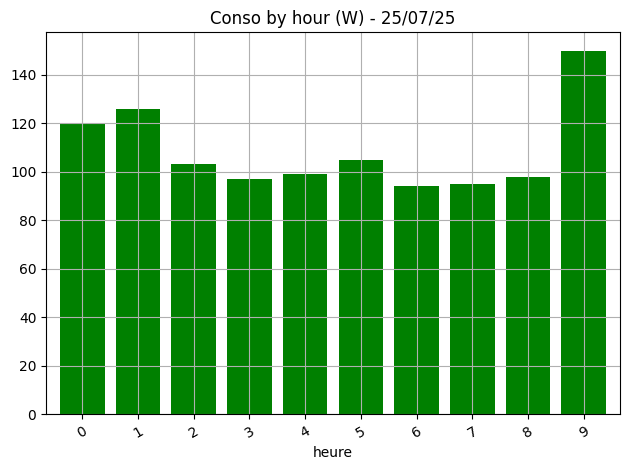

In [43]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [44]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311 entries, 18/09/24 to 25/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     311 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [45]:
# give the periods of 1 kwh in a day
period()

2025-07-25 00:00:19.208612	2025-07-25 09:37:25.614612	9h 37m 6s 	1000


In [46]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [47]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [48]:
df_grp.mean()


kWh    3.215434
dtype: float64

In [49]:
df_grp.head()


,kWh
days,
18/09/24,1.546
19/09/24,1.818
20/09/24,1.821
21/09/24,1.817
22/09/24,1.815


In [50]:
df_grp.tail()


,kWh
days,
21/07/25,3.594
22/07/25,3.574
23/07/25,3.257
24/07/25,2.969
25/07/25,1.087


In [51]:
end = time.time()
print(end - start)

27.237189292907715


# plot les 100 derniers jours


In [52]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.01386
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

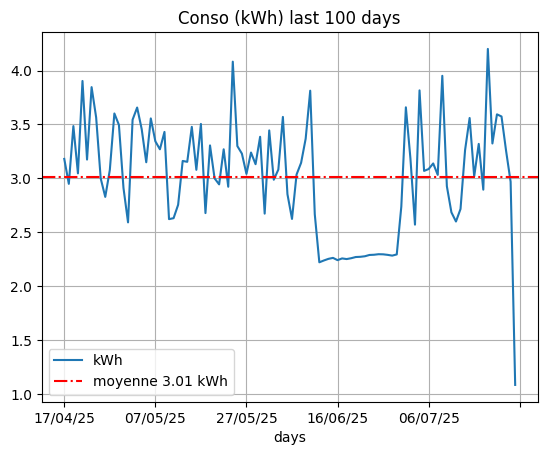

In [53]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [54]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.087
max,4.200


In [55]:
end = time.time()
print(end - start)

28.071114540100098


In [56]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('25/06/25', '20/07/25')

In [57]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.054233
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

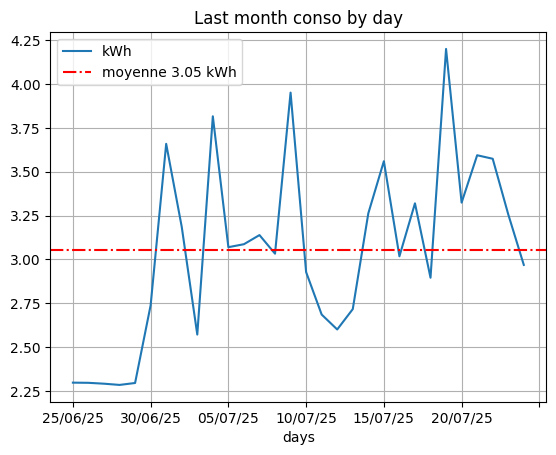

In [58]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [59]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 19/07/25 4.2
Min : 28/06/25 2.285


# Temps de conso par tranche de 1 kWh

In [60]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-07-25 00:00:19.208612	2025-07-25 09:37:25.614612	9h 37m 6s 	1000
2025-07-25 09:37:25.614612	2025-07-25 09:56:14.257612	0h 18m 48s 	87


In [61]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('09:56:32', 1.087, 1087)

In [62]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1087 entries, 998913 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1087 non-null   int64         
 1   kWh        1087 non-null   float64       
 2   sec        1087 non-null   float64       
 3   Wh         1087 non-null   float64       
 4   cumul(ms)  1087 non-null   int64         
 5   dates      1087 non-null   datetime64[ns]
 6   days       1087 non-null   object        
 7   heure      1087 non-null   object        
 8   hours      1087 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 84.9+ KB


In [63]:
conso_hours['heure'], conso_hours['hours']

(998913    0
 998914    0
 998915    0
 998916    0
 998917    0
          ..
 999995    9
 999996    9
 999997    9
 999998    9
 999999    9
 Name: heure, Length: 1087, dtype: object,
 998913    00
 998914    00
 998915    00
 998916    00
 998917    00
           ..
 999995    09
 999996    09
 999997    09
 999998    09
 999999    09
 Name: hours, Length: 1087, dtype: object)

In [64]:
end = time.time()
print(end - start)

29.355834007263184


# select number of days to display


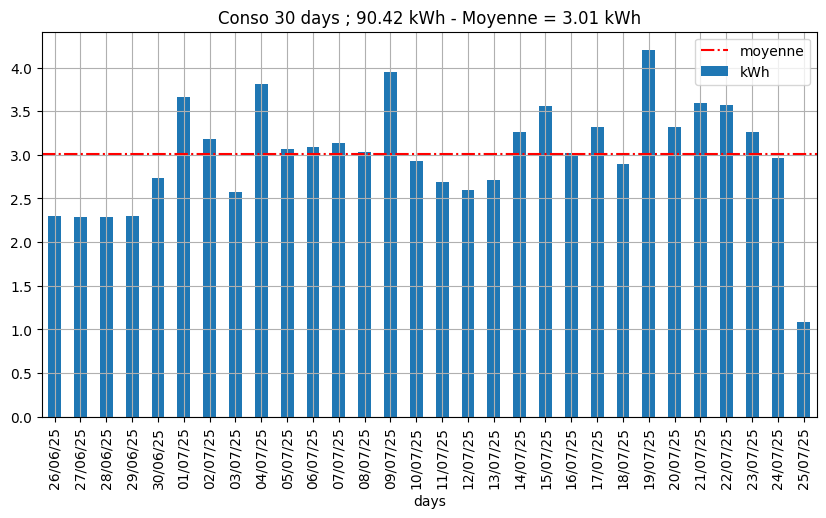

In [65]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


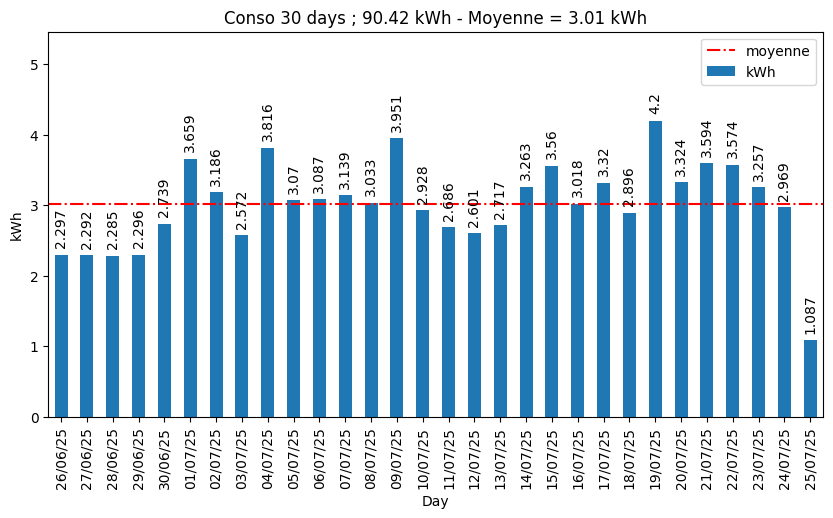

In [66]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [67]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
26/06/25    2.297
27/06/25    2.292
28/06/25    2.285
29/06/25    2.296
30/06/25    2.739
01/07/25    3.659
02/07/25    3.186
03/07/25    2.572
04/07/25    3.816
05/07/25    3.070
06/07/25    3.087
07/07/25    3.139
08/07/25    3.033
09/07/25    3.951
10/07/25    2.928
11/07/25    2.686
12/07/25    2.601
13/07/25    2.717
14/07/25    3.263
15/07/25    3.560
16/07/25    3.018
17/07/25    3.320
18/07/25    2.896
19/07/25    4.200
20/07/25    3.324
21/07/25    3.594
22/07/25    3.574
23/07/25    3.257
24/07/25    2.969
25/07/25    1.087
Name: kWh, dtype: float64

In [68]:
x_labels=df_grp.tail(span).index
x_labels

Index(['26/06/25', '27/06/25', '28/06/25', '29/06/25', '30/06/25', '01/07/25',
       '02/07/25', '03/07/25', '04/07/25', '05/07/25', '06/07/25', '07/07/25',
       '08/07/25', '09/07/25', '10/07/25', '11/07/25', '12/07/25', '13/07/25',
       '14/07/25', '15/07/25', '16/07/25', '17/07/25', '18/07/25', '19/07/25',
       '20/07/25', '21/07/25', '22/07/25', '23/07/25', '24/07/25', '25/07/25'],
      dtype='object', name='days')

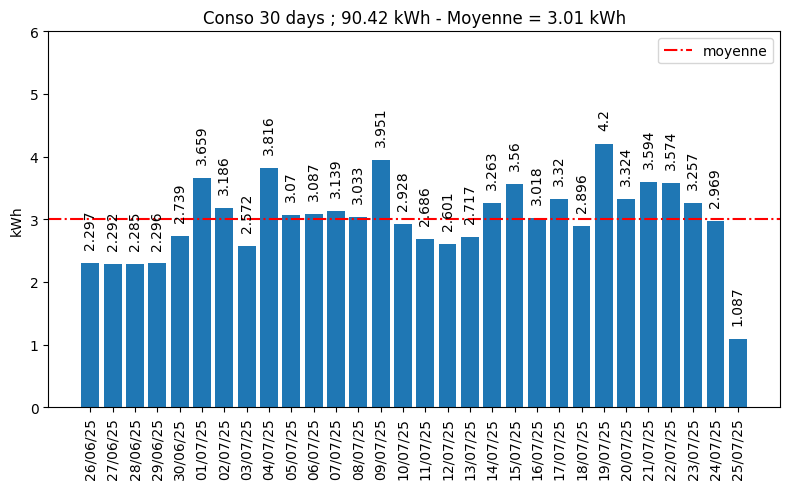

In [69]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [70]:
end = time.time()
print(end - start)

37.644869804382324


In [71]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

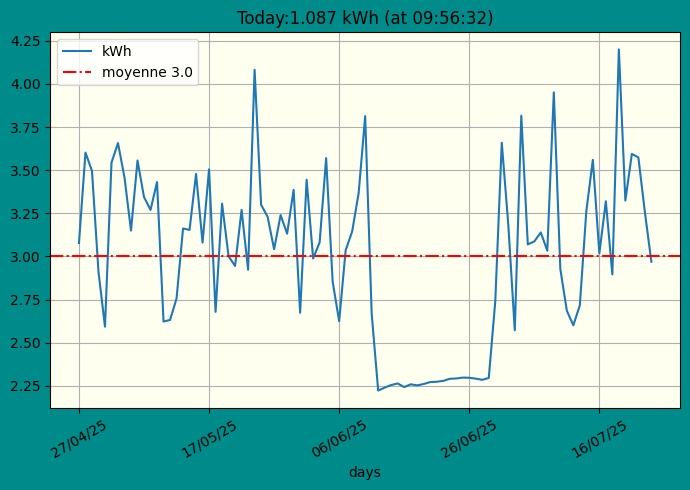

In [72]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

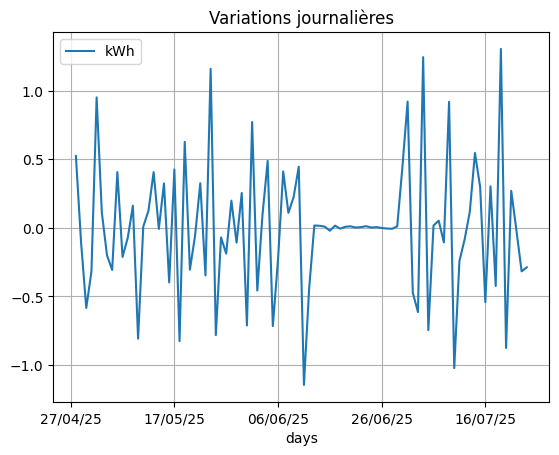

In [73]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [74]:
end = time.time()
print(end - start)

39.23678684234619


# Data from 21/08/23

In [75]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,45760,0.08,45.760,78.671329,45760,2024-09-18 03:16:56.280612,18/09/24,03,2024-09,18
1,45672,0.08,45.672,78.822911,91432,2024-09-18 03:17:41.952612,18/09/24,03,2024-09,18
2,45702,0.08,45.702,78.771170,137134,2024-09-18 03:18:27.654612,18/09/24,03,2024-09,18
3,45669,0.08,45.669,78.828089,182803,2024-09-18 03:19:13.323612,18/09/24,03,2024-09,18
4,47549,0.08,47.549,75.711371,230352,2024-09-18 03:20:00.872612,18/09/24,03,2024-09,18
...,...,...,...,...,...,...,...,...,...,...
999995,18930,0.19,18.930,190.174326,26807903406,2025-07-25 09:54:33.926612,25/07/25,09,2025-07,25
999996,18966,0.19,18.966,189.813350,26807922372,2025-07-25 09:54:52.892612,25/07/25,09,2025-07,25
999997,23885,0.15,23.885,150.722211,26807946257,2025-07-25 09:55:16.777612,25/07/25,09,2025-07,25
999998,28910,0.12,28.910,124.524386,26807975167,2025-07-25 09:55:45.687612,25/07/25,09,2025-07,25


In [76]:
end = time.time()
print(end - start)

78.91908717155457


In [77]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

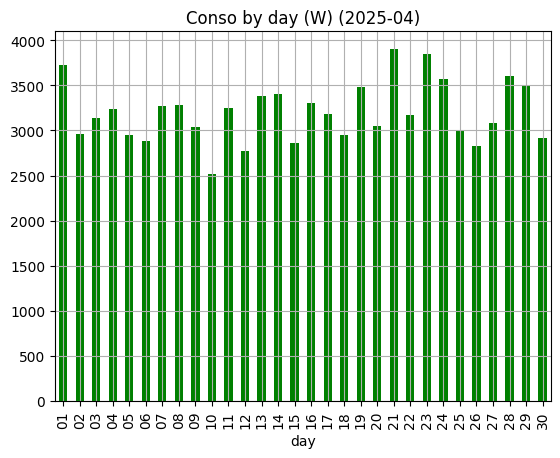

In [78]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [79]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3201.0333333333333)

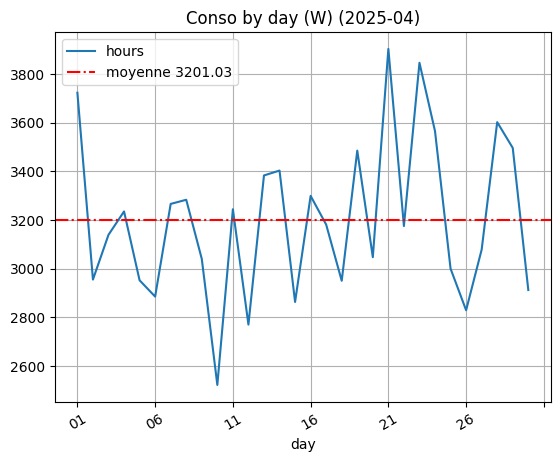

In [80]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [81]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

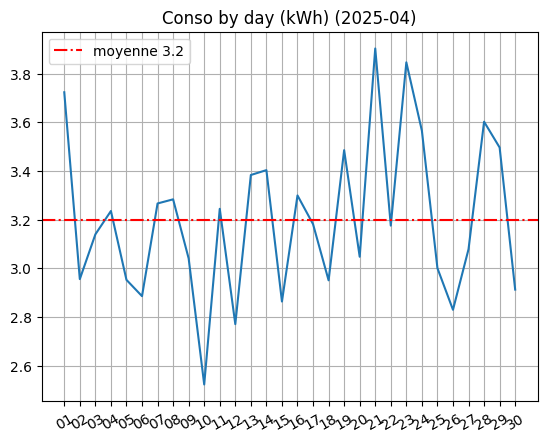

In [82]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [83]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [84]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [85]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,23226,23226,23226
2024-10,73310,73310,73310
2024-11,108172,108172,108172
2024-12,113973,113973,113973
2025-01,113895,113895,113895
2025-02,104265,104265,104265
2025-03,111811,111811,111811
2025-04,96031,96031,96031
2025-05,98602,98602,98602


In [86]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [87]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [88]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
18/09/24,1546
19/09/24,1818
20/09/24,1821
21/09/24,1817
22/09/24,1815
...,...
21/07/25,3594
22/07/25,3574
23/07/25,3257


In [89]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,45760,0.08,45.760,78.671329,45760,2024-09-18 03:16:56.280612,18/09/24,03,2024-09,18
1,45672,0.08,45.672,78.822911,91432,2024-09-18 03:17:41.952612,18/09/24,03,2024-09,18
2,45702,0.08,45.702,78.771170,137134,2024-09-18 03:18:27.654612,18/09/24,03,2024-09,18
3,45669,0.08,45.669,78.828089,182803,2024-09-18 03:19:13.323612,18/09/24,03,2024-09,18
4,47549,0.08,47.549,75.711371,230352,2024-09-18 03:20:00.872612,18/09/24,03,2024-09,18
...,...,...,...,...,...,...,...,...,...,...
999995,18930,0.19,18.930,190.174326,26807903406,2025-07-25 09:54:33.926612,25/07/25,09,2025-07,25
999996,18966,0.19,18.966,189.813350,26807922372,2025-07-25 09:54:52.892612,25/07/25,09,2025-07,25
999997,23885,0.15,23.885,150.722211,26807946257,2025-07-25 09:55:16.777612,25/07/25,09,2025-07,25
999998,28910,0.12,28.910,124.524386,26807975167,2025-07-25 09:55:45.687612,25/07/25,09,2025-07,25


In [90]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
18/09/24 03    0       18/09/24    03  0.08
               1       18/09/24    03  0.08
               2       18/09/24    03  0.08
               3       18/09/24    03  0.08
               4       18/09/24    03  0.08
...                         ...   ...   ...
25/07/25 09    999995  25/07/25    09  0.19
               999996  25/07/25    09  0.19
               999997  25/07/25    09  0.15
               999998  25/07/25    09  0.12
               999999  25/07/25    09  0.13

[1000000 rows x 3 columns]

In [91]:
groupallbyday.indices.keys()

dict_keys(['18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/11/24', '25/11/24', '26/11/24', '27/11/24', '28/11/24', '29/11/24', '30/11/24', '01/12/24', '02/12/24', '03/12/24', '04/12/24', '05/12/24', '06/12/24', '07/12/24', '08/12/24', '09/1

In [92]:
groupallbydayhours.indices.keys()

dict_keys([('18/09/24', '03'), ('18/09/24', '04'), ('18/09/24', '05'), ('18/09/24', '06'), ('18/09/24', '07'), ('18/09/24', '08'), ('18/09/24', '09'), ('18/09/24', '10'), ('18/09/24', '11'), ('18/09/24', '12'), ('18/09/24', '13'), ('18/09/24', '14'), ('18/09/24', '15'), ('18/09/24', '16'), ('18/09/24', '17'), ('18/09/24', '18'), ('18/09/24', '19'), ('18/09/24', '20'), ('18/09/24', '21'), ('18/09/24', '22'), ('18/09/24', '23'), ('19/09/24', '03'), ('19/09/24', '04'), ('19/09/24', '05'), ('19/09/24', '06'), ('19/09/24', '07'), ('19/09/24', '08'), ('19/09/24', '09'), ('19/09/24', '10'), ('19/09/24', '11'), ('19/09/24', '12'), ('19/09/24', '13'), ('19/09/24', '14'), ('19/09/24', '15'), ('19/09/24', '16'), ('19/09/24', '17'), ('19/09/24', '18'), ('19/09/24', '19'), ('19/09/24', '20'), ('19/09/24', '21'), ('19/09/24', '22'), ('19/09/24', '23'), ('19/09/24', '00'), ('19/09/24', '01'), ('19/09/24', '02'), ('20/09/24', '03'), ('20/09/24', '04'), ('20/09/24', '05'), ('20/09/24', '06'), ('20/09/2

In [93]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
18/09/24,1546,1546
19/09/24,1818,1818
20/09/24,1821,1821
21/09/24,1817,1817
22/09/24,1815,1815
...,...,...
21/07/25,3594,3594
22/07/25,3574,3574
23/07/25,3257,3257


In [94]:
grp_by_day['kWh'].cumsum()

days
18/09/24       1546
19/09/24       3364
20/09/24       5185
21/09/24       7002
22/09/24       8817
             ...   
21/07/25     989113
22/07/25     992687
23/07/25     995944
24/07/25     998913
25/07/25    1000000
Name: kWh, Length: 311, dtype: int64

In [95]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
18/09/24 03      54
         04      77
         05      75
         06      77
         07      77
...             ...
25/07/25 05     105
         06      94
         07      95
         08      98
         09     150

[7447 rows x 1 columns]

In [96]:
grp_by_dayhours['kWh'].cumsum()

days      hours
18/09/24  03            54
          04           131
          05           206
          06           283
          07           360
                    ...   
25/07/25  05        999563
          06        999657
          07        999752
          08        999850
          09       1000000
Name: kWh, Length: 7447, dtype: int64

In [97]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
18/09/24 03      54      54   NaN
         04      77     131  23.0
         05      75     206  -2.0
         06      77     283   2.0
         07      77     360   0.0
...             ...     ...   ...
25/07/25 05     105     650   6.0
         06      94     744 -11.0
         07      95     839   1.0
         08      98     937   3.0
         09     150    1087  52.0

[7447 rows x 3 columns]

In [98]:
today, grp_by_dayhours.loc[today]

('25/07/25',
        kWh  cumsum  diff
 hours                   
 00     120     120   NaN
 01     126     246   6.0
 02     103     349 -23.0
 03      97     446  -6.0
 04      99     545   2.0
 05     105     650   6.0
 06      94     744 -11.0
 07      95     839   1.0
 08      98     937   3.0
 09     150    1087  52.0)

Text(0.5, 1.0, 'Cumul journalier')

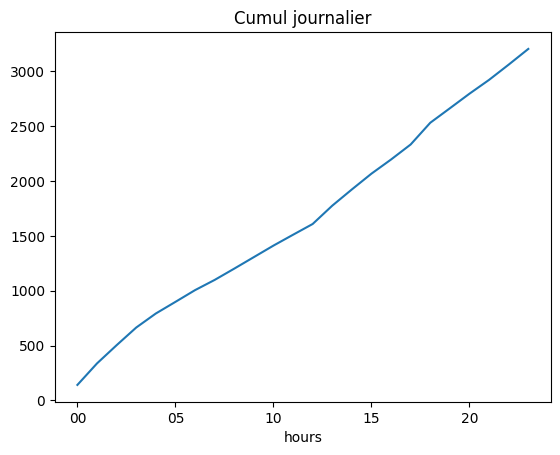

In [99]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

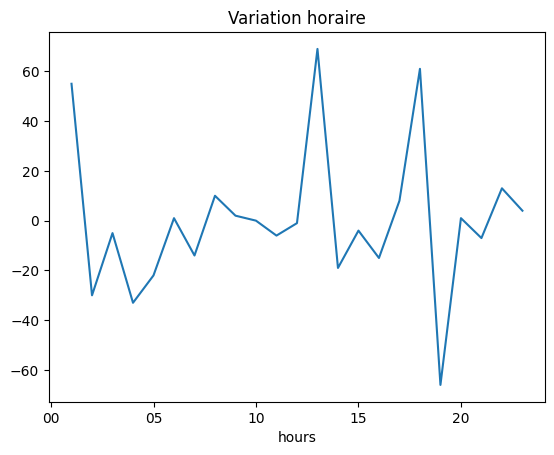

In [100]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [101]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

311

In [102]:
df_grp.tail(n)['kWh'].describe()


count    311.000000
mean       3.215434
std        0.714994
min        1.087000
25%        2.947500
50%        3.323000
75%        3.671000
max        4.784000
Name: kWh, dtype: float64

In [103]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [104]:
n, np.nanmean(df_grp.tail(n))

(311, np.float64(3.215434083601286))

Text(0.5, 1.0, '311 days')

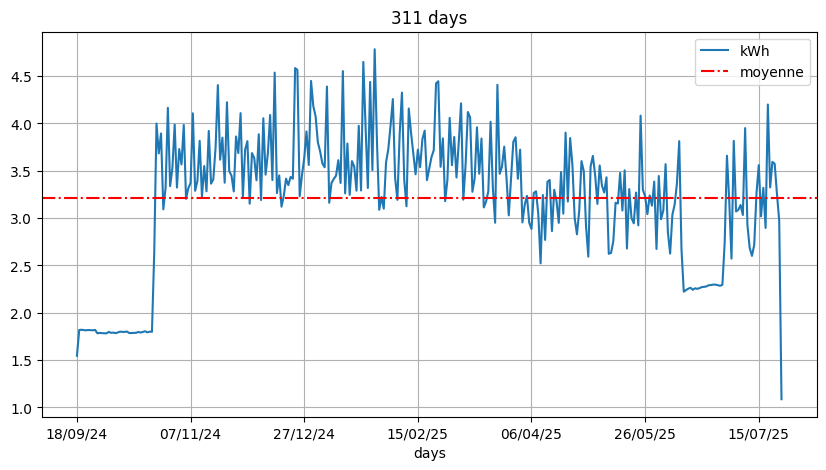

In [105]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

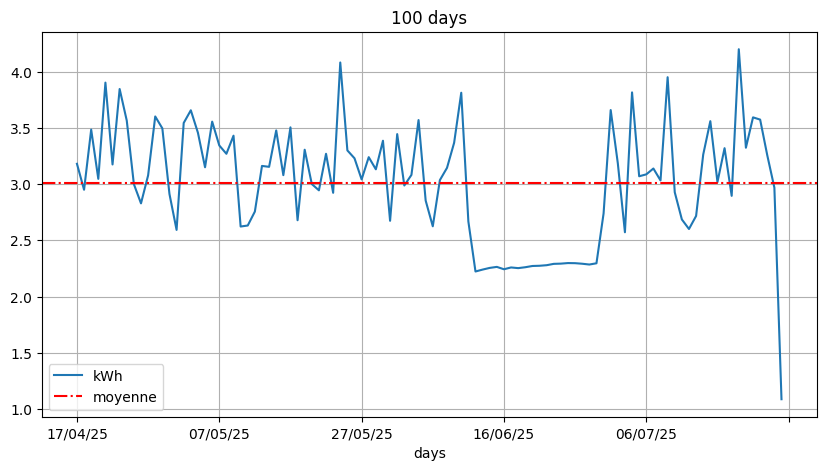

In [106]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [107]:
np.nanmean(df_grp.tail(span))

np.float64(3.0138599999999998)

In [108]:
df_grp['kWh']

days
18/09/24    1.546
19/09/24    1.818
20/09/24    1.821
21/09/24    1.817
22/09/24    1.815
            ...  
21/07/25    3.594
22/07/25    3.574
23/07/25    3.257
24/07/25    2.969
25/07/25    1.087
Name: kWh, Length: 311, dtype: float64

In [109]:
df_grp.describe()

,kWh
count,311.000000
mean,3.215434
std,0.714994
min,1.087000
25%,2.947500
50%,3.323000
75%,3.671000
max,4.784000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

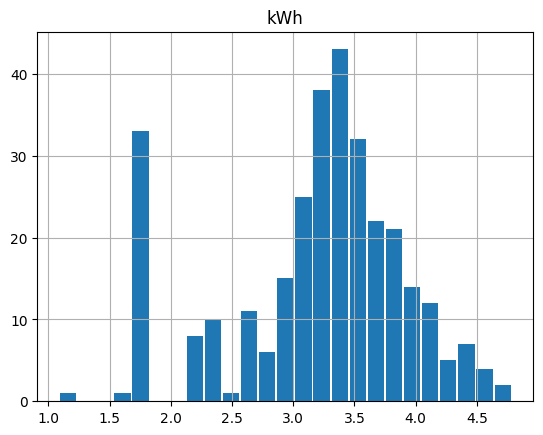

In [110]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [111]:
df_grp.tail(span)['kWh']

days
17/04/25    3.181
18/04/25    2.950
19/04/25    3.485
20/04/25    3.047
21/04/25    3.903
            ...  
21/07/25    3.594
22/07/25    3.574
23/07/25    3.257
24/07/25    2.969
25/07/25    1.087
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [112]:
day

'25/07/25'

In [113]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,120,120,NaN
01,126,246,6.0
02,103,349,-23.0
03,97,446,-6.0
04,99,545,2.0
05,105,650,6.0
06,94,744,-11.0
07,95,839,1.0
08,98,937,3.0


In [114]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


10

In [115]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 11)

In [116]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [117]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [118]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [119]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [120]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, 00 to 09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     10 non-null     int64  
 1   cumsum  10 non-null     int64  
 2   diff    9 non-null      float64
 3   days    10 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 400.0+ bytes


In [121]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
Name: days, dtype: float64

In [122]:
day

'25/07/25'

In [123]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,120,120,NaN,1.0
01,126,246,6.0,2.0
02,103,349,-23.0,3.0
03,97,446,-6.0,4.0
04,99,545,2.0,5.0
05,105,650,6.0,6.0
06,94,744,-11.0,7.0
07,95,839,1.0,8.0
08,98,937,3.0,9.0


In [124]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_17924\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(1.087)

In [125]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
18/09/24 03      54      54   NaN   NaN
         04      77     131  23.0   NaN
         05      75     206  -2.0   NaN
         06      77     283   2.0   NaN
         07      77     360   0.0   NaN
...             ...     ...   ...   ...
25/07/25 05     105     650   6.0   6.0
         06      94     744 -11.0   7.0
         07      95     839   1.0   8.0
         08      98     937   3.0   9.0
         09     150    1087  52.0  10.0

[7447 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '25/07/25: kWh    1.087\ndtype: float64')

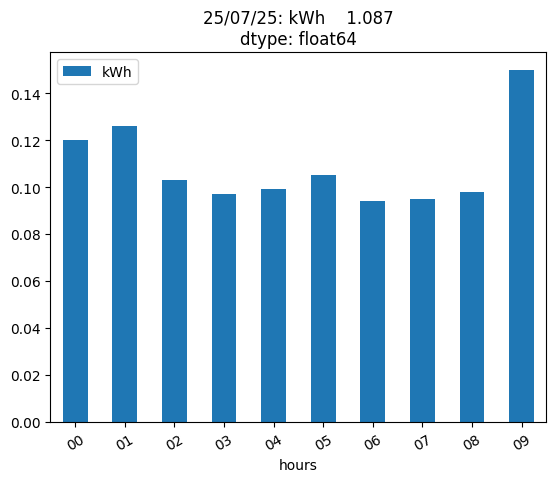

In [126]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [127]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09'], dtype='object', name='hours')

# Conso du jour


In [128]:
grp_by_dayhours.count()

kWh       7447
cumsum    7447
diff      7136
days        10
dtype: int64

'27/01/25'

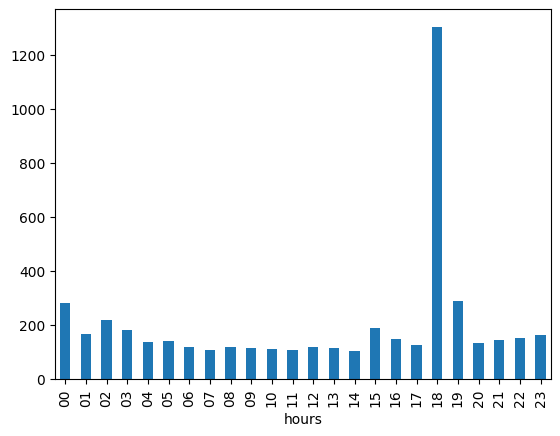

In [129]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [130]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 301.386 , Moyenne= 3.0138599999999998


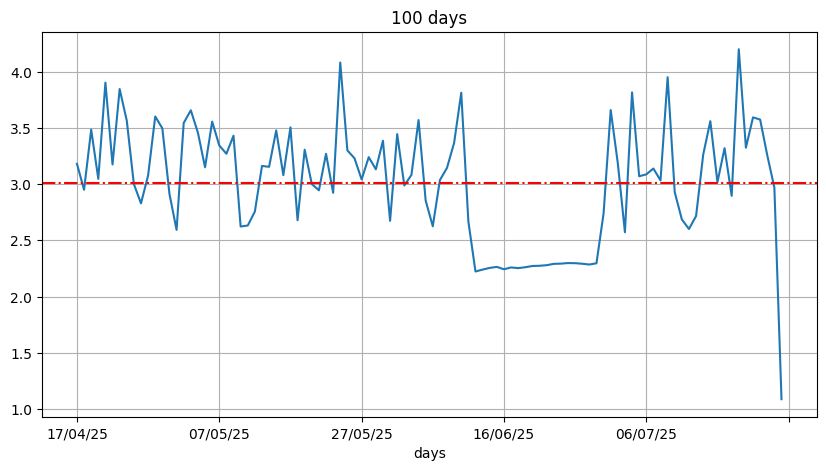

In [131]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [132]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 09:57:42, Minutes in day: 597


In [133]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [134]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:31.95


In [135]:
end - start

91.95073699951172

In [136]:
#df = conso_day
show_tranches()

2
2025-07-25 00:00:19.208612	2025-07-25 09:37:25.614612	9h 37m 6s 	1000
2025-07-25 09:37:25.614612	2025-07-25 09:56:14.257612	0h 18m 48s 	87


In [137]:
df_grp.tail(7)['kWh']

days
19/07/25    4.200
20/07/25    3.324
21/07/25    3.594
22/07/25    3.574
23/07/25    3.257
24/07/25    2.969
25/07/25    1.087
Name: kWh, dtype: float64

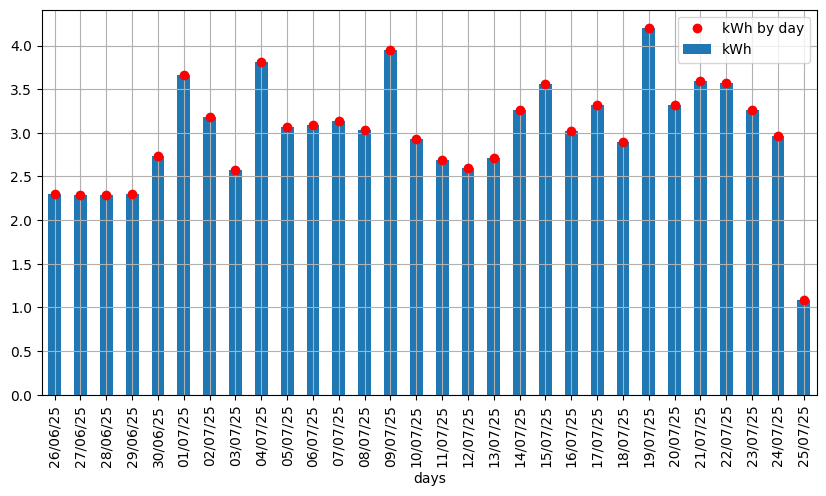

In [138]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

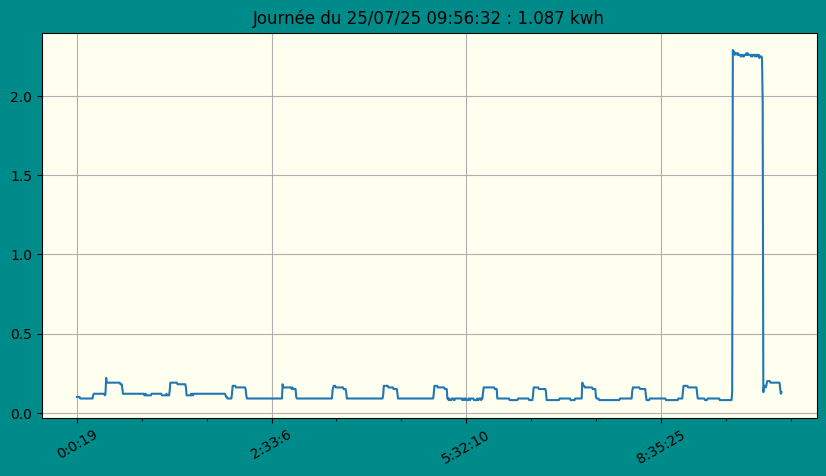

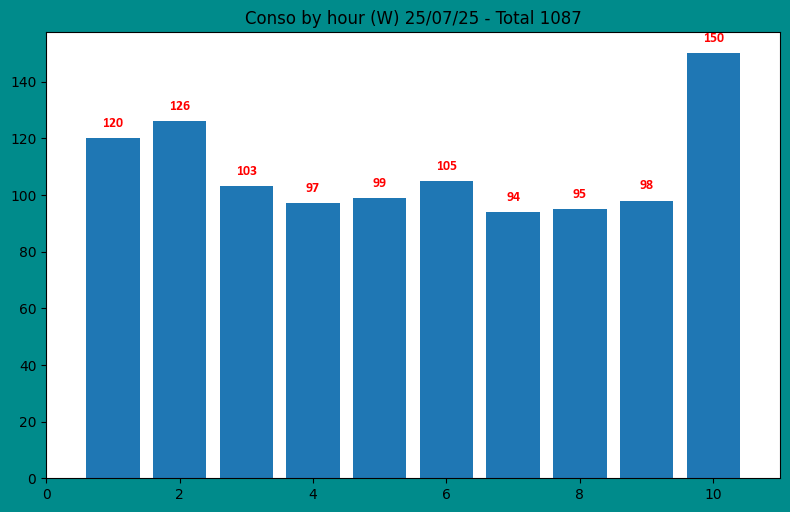

In [139]:
show(today,bgcolor='ivory')
conso_by_hour(today)

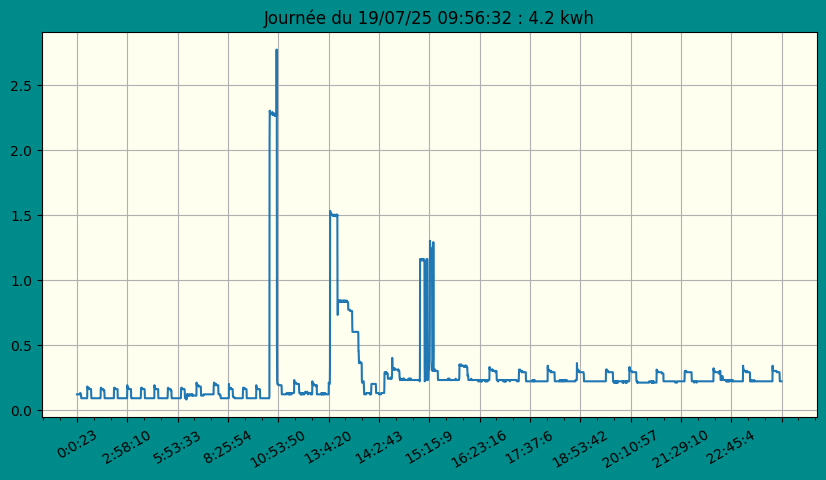

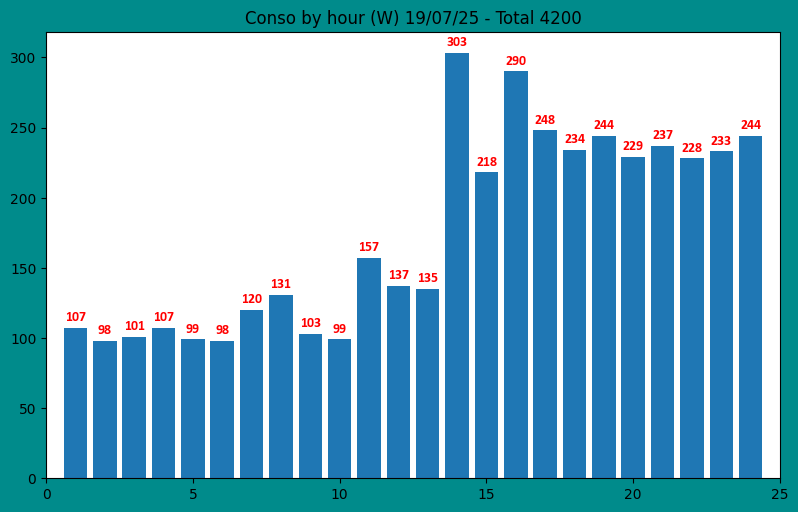

In [140]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
# 19/07/25 cuisine midi et télé le soir 4.21 kWh
day = '19/07/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4784)

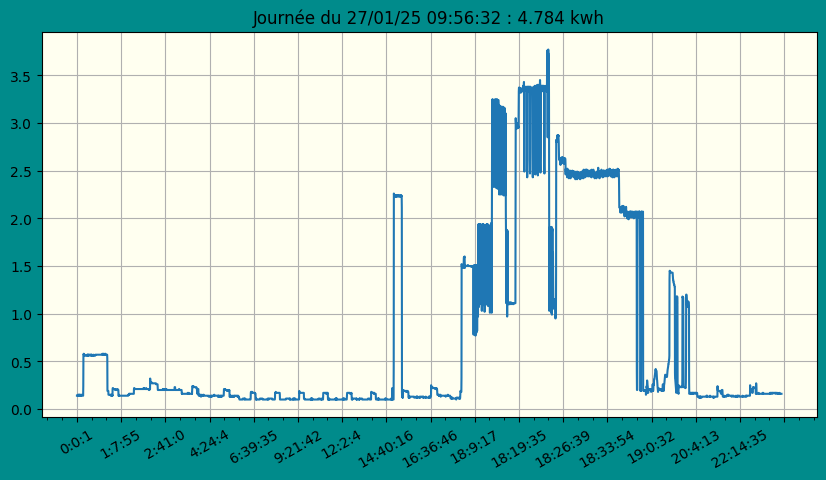

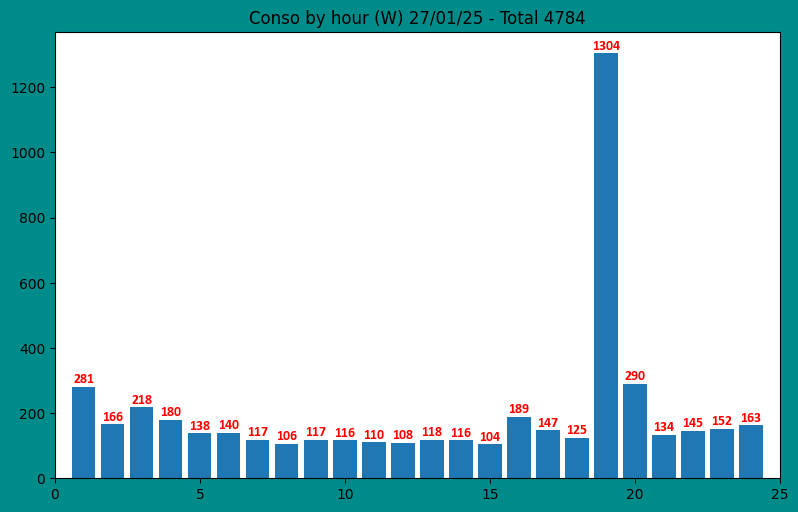

In [141]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

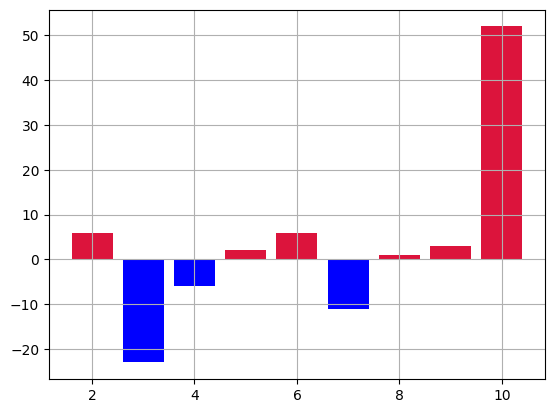

In [142]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

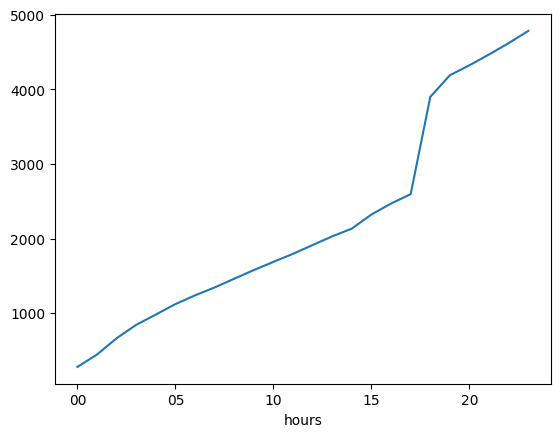

In [143]:
data.cumsum().plot()


<Axes: xlabel='hours'>

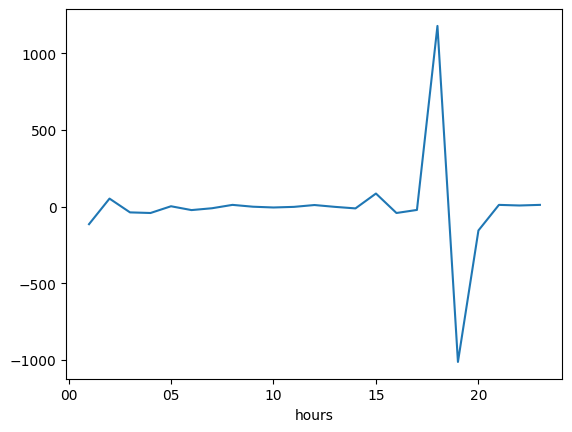

In [144]:
# evolution par heure
data.diff().plot()

In [145]:
data.diff().describe()

count      23.000000
mean       -5.130435
std       335.202287
min     -1014.000000
25%       -30.500000
50%        -2.000000
75%        10.500000
max      1179.000000
Name: kWh, dtype: float64

<Axes: >

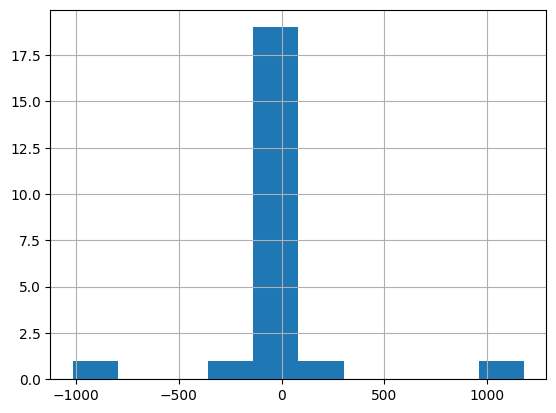

In [146]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [147]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'read_csv_conso.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_ch

# list store files csv


In [148]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

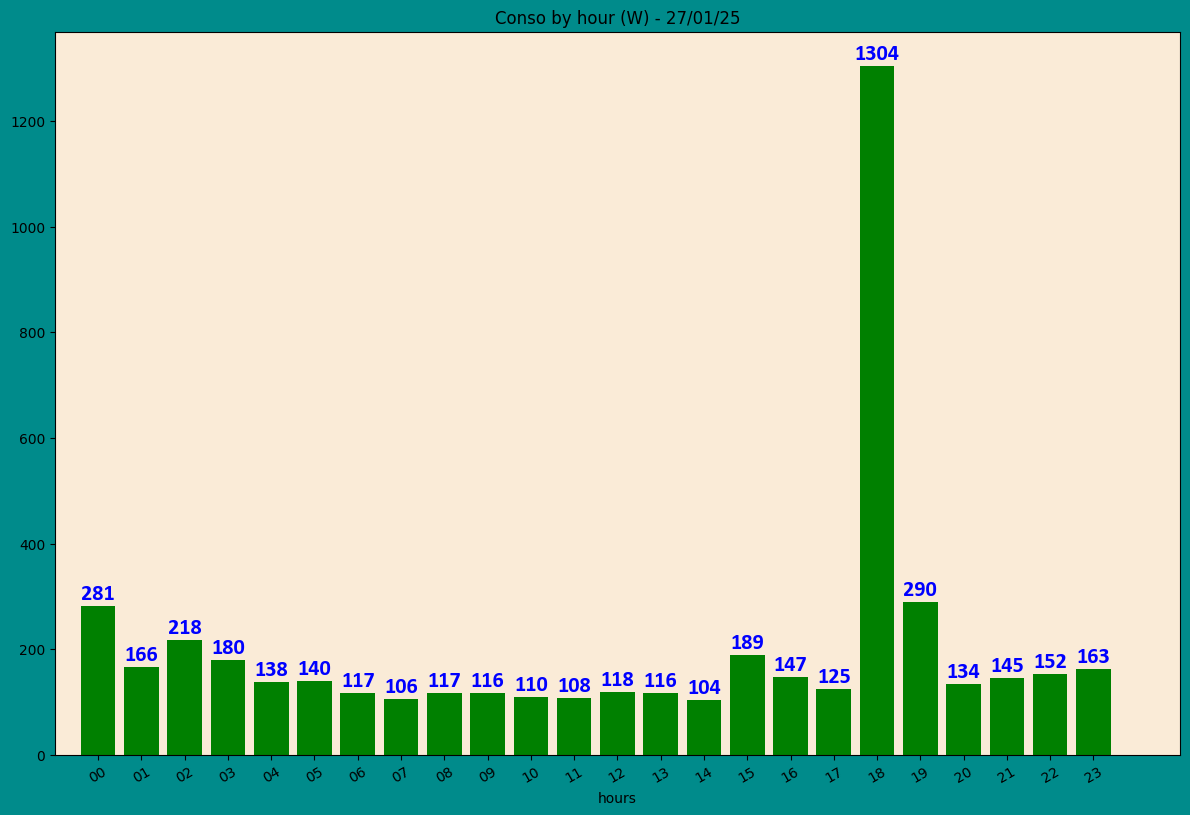

In [149]:
day,conso_byhour(day)

In [150]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


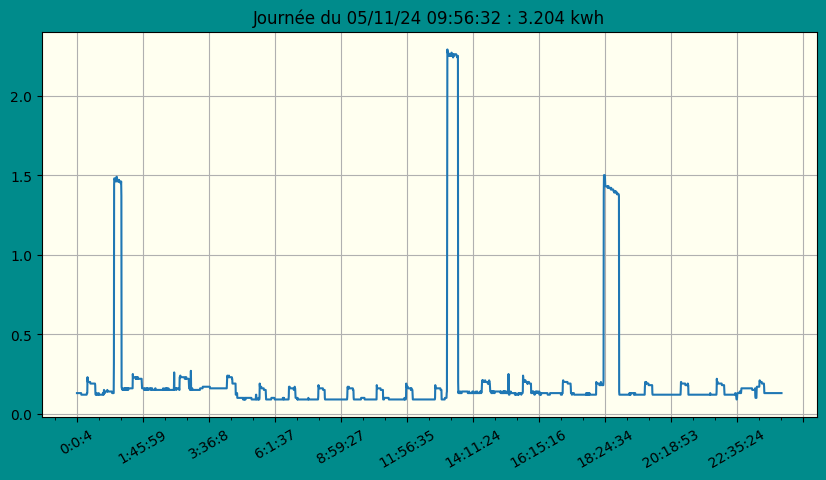

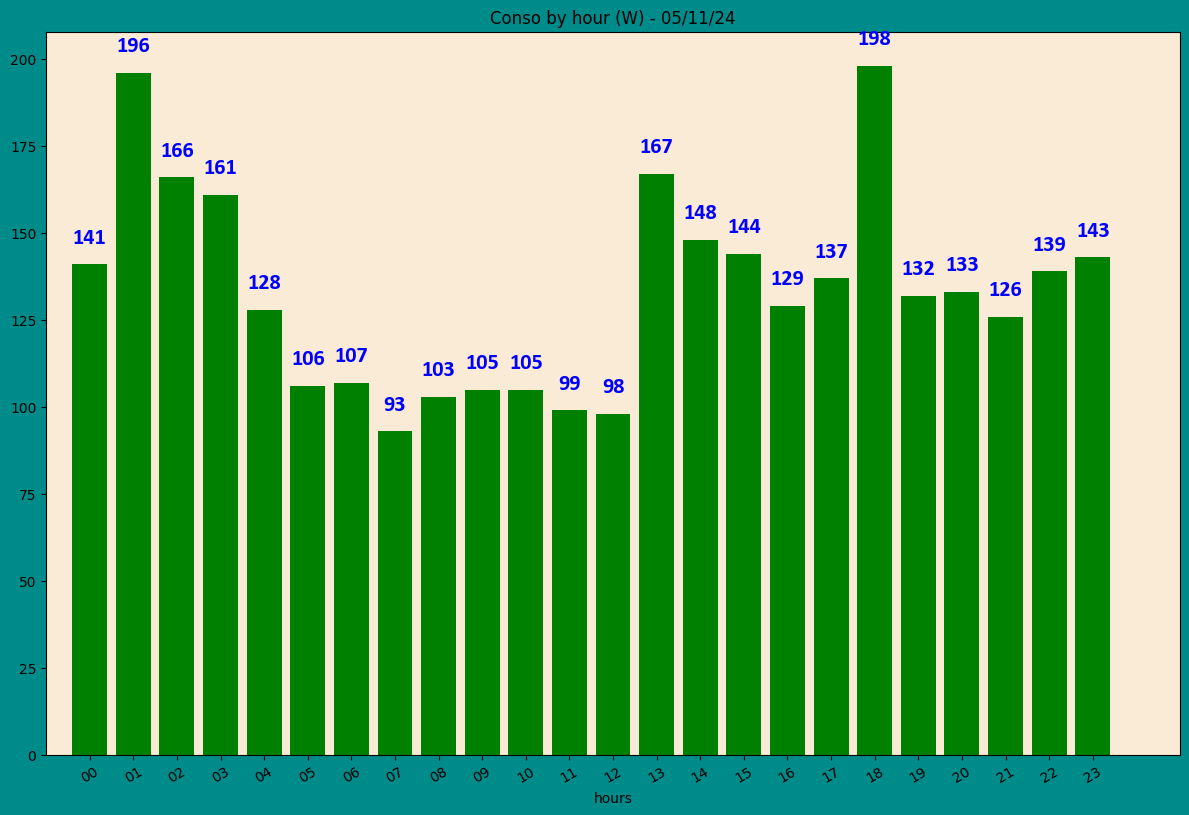

In [151]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [152]:
month

,day,hours,months,kWh
648652,01,00,2025-04,0.21
648653,01,00,2025-04,0.21
648654,01,00,2025-04,0.21
648655,01,00,2025-04,0.21
648656,01,00,2025-04,0.21
...,...,...,...,...
744678,30,23,2025-04,0.09
744679,30,23,2025-04,0.09
744680,30,23,2025-04,0.09
744681,30,23,2025-04,0.09


In [153]:
month.describe()


,kWh
count,96031.000000
mean,0.310187
std,0.547281
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

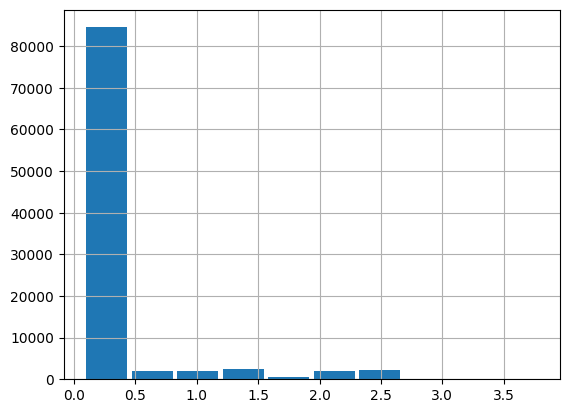

In [154]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

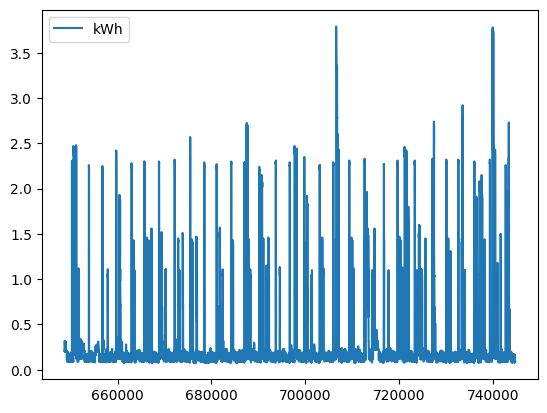

In [155]:
month.plot()

In [156]:
# index with max conso in this month
month.idxmax().kWh

np.int64(706557)

In [157]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       741771
hours     652214
months    648652
kWh       706557
dtype: int64

In [158]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [159]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
18/09/24 03      54      54   NaN   NaN
         04      77     131  23.0   NaN
         05      75     206  -2.0   NaN
         06      77     283   2.0   NaN
         07      77     360   0.0   NaN
...             ...     ...   ...   ...
25/07/25 05     105     650   6.0   6.0
         06      94     744 -11.0   7.0
         07      95     839   1.0   8.0
         08      98     937   3.0   9.0
         09     150    1087  52.0  10.0

[7447 rows x 4 columns]

In [160]:
month

,day,hours,months,kWh
648652,01,00,2025-04,0.21
648653,01,00,2025-04,0.21
648654,01,00,2025-04,0.21
648655,01,00,2025-04,0.21
648656,01,00,2025-04,0.21
...,...,...,...,...
744678,30,23,2025-04,0.09
744679,30,23,2025-04,0.09
744680,30,23,2025-04,0.09
744681,30,23,2025-04,0.09


In [161]:
month.idxmax()


day       741771
hours     652214
months    648652
kWh       706557
dtype: int64

In [162]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 706557, dtype: object

In [163]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       179
          01       176
          02       166
          03       137
          04       114
          05       111
          06       100
          07       109
          08       111
          09       110
          10        98
          11       109
          12       163
          13       144
          14       136
          15       145
          16       144
          17       200
          18       150
          19       183
          20       160
          21       147
          22       142
          23       170
Name: kWh, dtype: int64

In [164]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'17'

<Axes: xlabel='days,hours'>

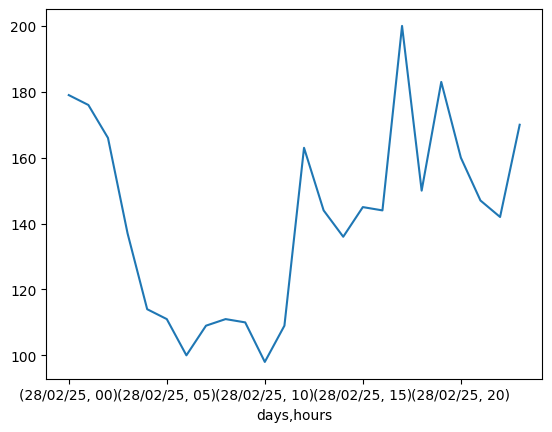

In [165]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [166]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [167]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [168]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [169]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB